In [1]:
# ensure relative imports are correctly imported
import sys
sys.path.insert(0, '../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.QuantumMachine import QuantumMachine
from qm.qua import *

from instruments import LabBrick, MetaInstrument, Sa124
from instruments.quantum_machines.configuration import *

from measurements.routines import resonator_spectroscopy_new as rr_spec
from measurements.routines import resonator_spectroscopy

In [3]:
# define a qubit
class Qubit(MetaInstrument):
    """
    Encapsulates a qubit.
    """
    def __init__(self, name: str, lo_freq: float):
        self.name = name
        self.lo_freq = lo_freq
    
    def _create_parameters(self):
        print("created dummy parameters for " + self.name)
    
    def _create_yaml_map(self):
        return {
            'lo_freq': self.lo_freq
        }

# instantiate the qubit
qubit = Qubit(name='qubit', lo_freq=4.165e9)

In [4]:
# define a resonator
class Resonator(MetaInstrument):
    """
    Encapsulates a resonator.
    """
    def __init__(self, name: str, lo_freq: float):
        self.name = name
        self.lo_freq = lo_freq
    
    def _create_parameters(self):
        print("created dummy parameters for " + self.name)
    
    def _create_yaml_map(self):
        return {
            'lo_freq': self.lo_freq
        }

# instantiate the resonator
rr = Resonator(name='rr', lo_freq=8.7571e9)

In [5]:
sa = Sa124(name='sa', serial_number=19184645, center=8.7e9, span=200e6)

Trying to initialize sa
Error -8: {'error_string': b'Device not found'} in sa_open_device_by_serial()
Closing and reinitializing it. Use configure_sweep() to change sweep parameters instead of __init__()
Error -3: {'error_string': b'Device specified is not open'} in sa_close_device()


NameError: name 'exit' is not defined

In [ ]:
sa.disconnect()

In [5]:
# start the qm
qmm = QuantumMachinesManager()
qm = qmm.open_qm(config)

2021-04-20 15:48:13,610 - qm - INFO - Performing health check
2021-04-20 15:48:13,616 - qm - INFO - Health check passed


In [6]:
# We have tuned the IQ mixer according to the tutorial-2-2-SA124B-MixerTuning.ipynb document.
# These are key numbers obtained:
rr_dcOffsetI = 0.011558358245951837
rr_dcOffsetQ = -0.00947436793762317
rr_mixerGainCorrection = -0.15430981633780644
rr_mixerPhaseCorrection = 0.0212698142172309

q_dcOffsetI = -0.00647755186574999 
q_dcOffsetQ = -0.011624171790995147
q_mixerGainCorrection = -0.19547425898369505
q_mixerPhaseCorrection = 0.05154287262922243

# after this step we have tuned the IQ mixer.
qm.set_output_dc_offset_by_element("rr", "I", float(rr_dcOffsetI)) 
qm.set_output_dc_offset_by_element("rr", "Q", float(rr_dcOffsetQ))
qm.set_mixer_correction("mixer_rr", rr_IF, rr_LO, IQ_imbalance(rr_mixerGainCorrection, rr_mixerPhaseCorrection))
qm.set_output_dc_offset_by_element("qubit", "I", float(q_dcOffsetI)) 
qm.set_output_dc_offset_by_element("qubit", "Q", float(q_dcOffsetQ))
qm.set_mixer_correction("mixer_qubit", qubit_IF, qubit_LO, IQ_imbalance(rr_mixerGainCorrection, q_mixerPhaseCorrection))

In [7]:
# start the labbricks
lb_q = LabBrick(name='lb_q', serial_number=25331, element=qubit, power=15)
lb_rr = LabBrick(name='lb_rr', serial_number=25335, element=rr, power=13)

Trying to initialize lb_q
Connnected to LabBrick 25331
creating parameters...
Initializing device...
Successfully set frequency to 4.16E+09
Successfully set power to +15
Trying to initialize lb_rr
Connnected to LabBrick 25335
creating parameters...
Initializing device...
Successfully set frequency to 8.76E+09
Successfully set power to +13


In [ ]:
lb_q.disconnect()
lb_rr.disconnect()

In [ ]:
# Setting the lab brick frequency
lb_q.frequency = 4.165e9

### Using the Spectrum Analyzer

In [24]:
# QUA script
with program() as cw:
    with infinite_loop_():
        play("CW", "rr")
        play("CW", "qubit")

# Execute the script
job = qm.execute(cw)

2021-04-20 15:52:15,462 - qm - INFO - Flags: 
2021-04-20 15:52:15,462 - qm - INFO - Executing high level program


In [25]:
# Spectrum analyzer sweep
sa.configure_sweep(center=8.7571e9, span=200e6, ref_power = -20)

# Plot
freqs, amps = sa.sweep()
plt.plot(freqs, amps)

NameError: name 'sa' is not defined

In [26]:
# Stopping the job
job.halt()

True

### Resonator spectroscopy

In [8]:
F_START = -47.0e6
F_STOP = -48.5e6
F_STEP = -0.01e6
F_VEC = np.arange(F_START, F_STOP, F_STEP)
REPS = 400
WAIT_TIME = 20000.
rr_ascale = 1.

# amplitude_volts = 0.32*rr_amp_scale
# try to keep amplitude_volts < 0.4 V (otherwise the pulse can be deformed)
RR_spec = rr_spec.ResonatorSpectroscopy('rr_spec', qm, REPS, 
                                        WAIT_TIME, F_VEC, rr_ascale, 
                                        qubit_ascale = 0.001, 
                                        qubit_pulse = 'saturation')

#amps_020_4000 = np.abs(I_list + 1j*Q_list)

#freqs = F_VEC/1e6
#plt.plot(freqs, amps_020_4000)

In [27]:
script = RR_spec._script()
queued_job = qm.queue.add(script)

[-47000000. -47010000. -47020000. -47030000. -47040000. -47050000.
 -47060000. -47070000. -47080000. -47090000. -47100000. -47110000.
 -47120000. -47130000. -47140000. -47150000. -47160000. -47170000.
 -47180000. -47190000. -47200000. -47210000. -47220000. -47230000.
 -47240000. -47250000. -47260000. -47270000. -47280000. -47290000.
 -47300000. -47310000. -47320000. -47330000. -47340000. -47350000.
 -47360000. -47370000. -47380000. -47390000. -47400000. -47410000.
 -47420000. -47430000. -47440000. -47450000. -47460000. -47470000.
 -47480000. -47490000. -47500000. -47510000. -47520000. -47530000.
 -47540000. -47550000. -47560000. -47570000. -47580000. -47590000.
 -47600000. -47610000. -47620000. -47630000. -47640000. -47650000.
 -47660000. -47670000. -47680000. -47690000. -47700000. -47710000.
 -47720000. -47730000. -47740000. -47750000. -47760000. -47770000.
 -47780000. -47790000. -47800000. -47810000. -47820000. -47830000.
 -47840000. -47850000. -47860000. -47870000. -47880000. -47890

FailedToAddJobToQueueException: 

In [9]:
RR_spec.queue_job()

2021-04-20 15:34:46,121 - qm - INFO - Flags: 
2021-04-20 15:34:46,121 - qm - INFO - Executing high level program
2021-04-20 15:34:46,136 - qm - ERROR - Job  failed. Failed to execute program.


FailedToAddJobToQueueException: 

2021-04-20 15:35:12,820 - qm - INFO - Flags: 
2021-04-20 15:35:12,820 - qm - INFO - Executing high level program


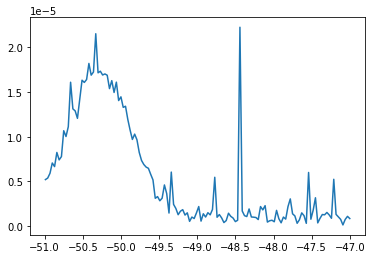

In [11]:
F_START = -47.0e6
F_STOP = -51e6
F_STEP = -0.03e6
F_VEC = np.arange(F_START, F_STOP, F_STEP)
REPS = 4000
WAIT_TIME = 20000
rr_amp_scale = 1

I_list, Q_list = resonator_spectroscopy.run(qm, F_START, F_STOP, F_STEP, REPS, WAIT_TIME, 
                                            rr_amp_scale, qubit_amp_scale = None)

amps_2 = np.abs(I_list + 1j*Q_list)
freqs = F_VEC/1e6
plt.plot(freqs, amps_2)

### Resonator power level sweep

In [ ]:
REPS = 1000
AMP_START = 0.2
AMP_STOP = 0.9
AMP_STEP = 0.01
AMP_VEC = np.arange(AMP_START, AMP_STOP, AMP_STEP)
BUFFER_SIZE = len(AMP_VEC)
WAIT_TIME = 20000
rr_IF = -50e6

I_list, Q_list = resonator_power_level.run(qm, AMP_START, AMP_STOP, AMP_STEP, REPS, WAIT_TIME, 
                                           rr_IF, qubit_amp_scale = None)

In [ ]:
contrast = np.abs(I_list + 1j*Q_list)
plt.figure(figsize=(10,8))
plt.plot(AMP_VEC, contrast)
plt.grid()

### Qubit spectroscopy

In [ ]:
F_START = -40.0e6
F_STOP = -60.0e6
F_STEP = -0.1e6
F_VEC = np.arange(F_START, F_STOP, F_STEP)
REPS = 4000
WAIT_TIME = 70000
rr_amp_scale = 0.02
rr_IF = -47.5e6
qubit_amp_scale = 1.
qubit_LO = 4.165e9
lb_q.frequency = qubit_LO

I_list, Q_list = qubit_spectroscopy.run(qm, F_START, F_STOP, F_STEP, REPS, WAIT_TIME, 
                                        rr_amp_scale, rr_IF, qubit_amp_scale)


In [ ]:
amps = np.abs(I_list + 1j*Q_list)
freqs = F_VEC/1e6

plt.figure(figsize=(15, 6), dpi=80)
plt.plot(freqs, amps)
plt.xlabel('Freq (MHz)')
plt.ylabel('|Amp|')
plt.grid()
plt.legend()

### Qubit spectroscopy with varying LO

In [ ]:
qubit_LO_range = [4.170e9,]# 4.360e9, 4.542e9, 4.732e9, 4.922e9, 5.112e9, 5.302e9, 5.492e9]

F_START = 100e6
F_STOP = -100e6
F_STEP = -0.02e6
F_VEC = np.arange(F_START, F_STOP, F_STEP)
REPS = 4000
WAIT_TIME = 100000

rr_amp_scale = 0.02
rr_IF = -47.25e6
qubit_amp_scale = 1.25

# Each element of output_list corresponds to an LO value and is a dictionary containing I and Q lists 
output_list = []
for qubit_LO in qubit_LO_range:
    lb_q.frequency = qubit_LO
    I_list, Q_list = qubit_spectroscopy.run(qm, F_START, F_STOP, F_STEP, REPS, WAIT_TIME, 
                                            rr_amp_scale, rr_IF, qubit_amp_scale)
    output_list.append({'I': I_list, 'Q': Q_list})

In [ ]:
config['pulses']['saturation_pulse']

In [ ]:
for i, output in enumerate(output_list):
    I_list = output['I']
    Q_list = output['Q']
    amps = np.abs(I_list + 1j*Q_list)
    
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(F_VEC/1e6, amps, )#marker='o', markersize=6, ls='')
    plt.title('Qubit_spec, 4k reps, 100us wait time \n sat. a=1.25, meas. a=0.02 (low power peak) and freq = -47.25MHz, tof = 824 ns, qubit_LO = %.3fGHz' % (qubit_LO_range[i]/1e9))
    plt.xlabel('Freq (MHz)')
    plt.ylabel('|Amp|')
    plt.grid()
    plt.legend()
    plt.savefig('qubit_spec_LO_%.3fGHz.png' % (qubit_LO_range[i]/1e9))

### Qubit Power Rabi

In [ ]:
REPS = 4000
AMP_START = -1.6
AMP_STOP = 0.0
AMP_STEP = 0.02
WAIT_TIME = 70000
rr_amp_scale = 0.02
qubit_LO = 4.165e9
lb_q.frequency = qubit_LO

I_list, Q_list = power_rabi.run(qm, AMP_START, AMP_STOP, AMP_STEP, REPS, 
                                WAIT_TIME, rr_amp_scale, pulse = 'saturation')

In [ ]:
amps = np.abs(I_list + 1j*Q_list)
AMP_VEC = np.arange(AMP_START, AMP_STOP, AMP_STEP)

plt.figure(figsize=(12, 8), dpi=80)
plt.plot(AMP_VEC, amps)

plt.xlabel('Amplitude scaling')
plt.ylabel('contrast')
plt.grid()
plt.legend()

### T1 measurement

In [ ]:
REPS = 4000
TAU_START = 24 
TAU_STOP = 50000
TAU_STEP = 100 
TAU_VEC = np.arange(TAU_START, TAU_STOP, TAU_STEP)
WAIT_TIME = 100000 # wait for cavity to relax to ground state

qubit_amp_scale = 1.0
rr_amp_scale = 0.02
qubit_LO = 4.165e9

lb_q.frequency = qubit_LO

I_list, Q_list = qubit_T1.run(qm, TAU_START, TAU_STOP, TAU_STEP, REPS, 
                                WAIT_TIME, rr_amp_scale, qubit_amp_scale)


In [ ]:
amps = np.abs(I_list + 1j*Q_list)
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(TAU_VEC/1e3, amps)

#plt.title('Qubit_spec, -50MHz to -1MHz 0.2MHz step for 2k reps \n sat. a=0.7, meas. a=1.25 and freq = -49.80MHz, tof = 824 ns, qubit_LO = 4.382e9')
plt.xlabel(r'Delay ($\mu$s)')
plt.ylabel('contrast')
plt.grid()
plt.legend()

### Low-power readout contrast for different wait times

In [ ]:
REPS = 8000
AMP_START = 0.001
AMP_STOP = 0.07
AMP_STEP = 0.0005
AMP_VEC = np.arange(AMP_START, AMP_STOP, AMP_STEP)
BUFFER_SIZE = len(AMP_VEC)
WAIT_TIME_list = [60000, 62500, 65000, 67500, 70000, 72500, 75000, 77500, 80000, 82500, 85000, 87500, 90000, 92500, 95000, 97500, 100000, 102500, 105000]
rr_IF = -47.25e6
qubit_amp_scale = 1.0
qubit_LO = 4.165e9
lb_q.frequency = qubit_LO

# Each element of output_list corresponds to an WAIT_TIME_list value and is a dictionary containing I and Q lists 
output_pi_pulse_list = []
output_zero_pulse_list = []

for WAIT_TIME in WAIT_TIME_list:
    
    I_list, Q_list = resonator_power_level.run(qm, AMP_START, AMP_STOP, AMP_STEP, REPS, WAIT_TIME, 
                                               rr_IF, qubit_amp_scale = qubit_amp_scale, pulse = 'gaussian')
    output_pi_pulse_list.append({'I': I_list, 'Q': Q_list})
    
    I_list, Q_list = resonator_power_level.run(qm, AMP_START, AMP_STOP, AMP_STEP, REPS, WAIT_TIME, 
                                               rr_IF, qubit_amp_scale = 0.00001, pulse = 'gaussian')
    output_zero_pulse_list.append({'I': I_list, 'Q': Q_list})

In [ ]:
plt.figure(figsize=(15, 8), dpi=80)

index_list = [4, 16]
for i, output in enumerate(output_pi_pulse_list):
    if i not in index_list:
        continue
    I_list = output_pi_pulse_list[i]['I']
    Q_list = output_pi_pulse_list[i]['Q']
    I_list_0 = output_zero_pulse_list[i]['I']
    Q_list_0 = output_zero_pulse_list[i]['Q']
    
    amps = np.abs(I_list + 1j*Q_list)
    amps_0 = np.abs(I_list_0 + 1j*Q_list_0)
    
    plt.plot(AMP_VEC, amps_0 - amps, label = '%.1f us' % (WAIT_TIME_list[i]/1e3))#marker='o', markersize=6, ls='')

plt.title('Low-power readout contrast as a function of RO amplitude scaling and wait time.\n 8k reps, meas. f = -47.25e6 and 1us pulse length, tof = 824 ns')
plt.xlabel('Freq (MHz)')
plt.ylabel('|Amp|')
plt.grid()
plt.legend()
plt.savefig('qubit_spec_LO_%.dGHz.png' % (WAIT_TIME_list[i]))

In [ ]:
# play CW on qm
with program() as cw:
    with infinite_loop_():
        play('CW', qubit.name)
        play('CW', rr.name)
job = qm.execute(cw)

In [ ]:
# connect to the spectrum analyzer
sa = Sa124(name = 'sa', serial_number = 19184645)

In [ ]:
# acquire spectrum
sa.configure_sweep(center = qubit.lo_freq, span = 100e6)
freqs, amps = sa.sweep()
plt.plot(freqs, amps)

In [ ]:
# acquire another spectrum
sa.configure_sweep(center=6e9, span=250e6)
freqs, amps = sa.sweep()
plt.plot(freqs, amps)

In [ ]:
sa.disconnect()
job.halt()